In [1]:
from omegaconf import DictConfig, OmegaConf
from DataInit import DataManager, RewardDataManager
import DataInit
from Exp4DataManager import Exp4DataManager

In [2]:
# 配置管理
config = DataInit.config_manager()

# 路径管理
global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path = DataInit.path_manager(config)


---------- Config Info ----------
path:
  global_path: /home/alex4060/PythonProject/MScProject/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda_load: 0.5
  top_k:
  - 1
  - 2
  - 3
  - 4
  - 5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_std: 10.0
    node_load_iid_std: 5.0
    node_load_ar1_theta: 0.9
    node_load_ar1_std: 80.0
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_std: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    iid:
      alpha_load_0: 30.0
      alpha_latency_1: 0.035
    ar1:
      alpha_load_0: 30.0
      alpha_latency_1: 0.086
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
   

---------- Reward Data Info ----------
iid_load_original.shape: (10, 11000)
iid_load_reward_0.shape: (10, 11000)
iid_load_reward_1.shape: (10, 11000)
iid_latency_original.shape: (10, 11000)
iid_latency_reward_1.shape: (10, 11000)
ar1_load_original.shape: (10, 11000)
ar1_load_reward_0.shape: (10, 11000)
ar1_load_reward_1.shape: (10, 11000)
ar1_latency_original.shape: (10, 11000)
ar1_latency_reward_1.shape: (10, 11000)
--------------------------------------


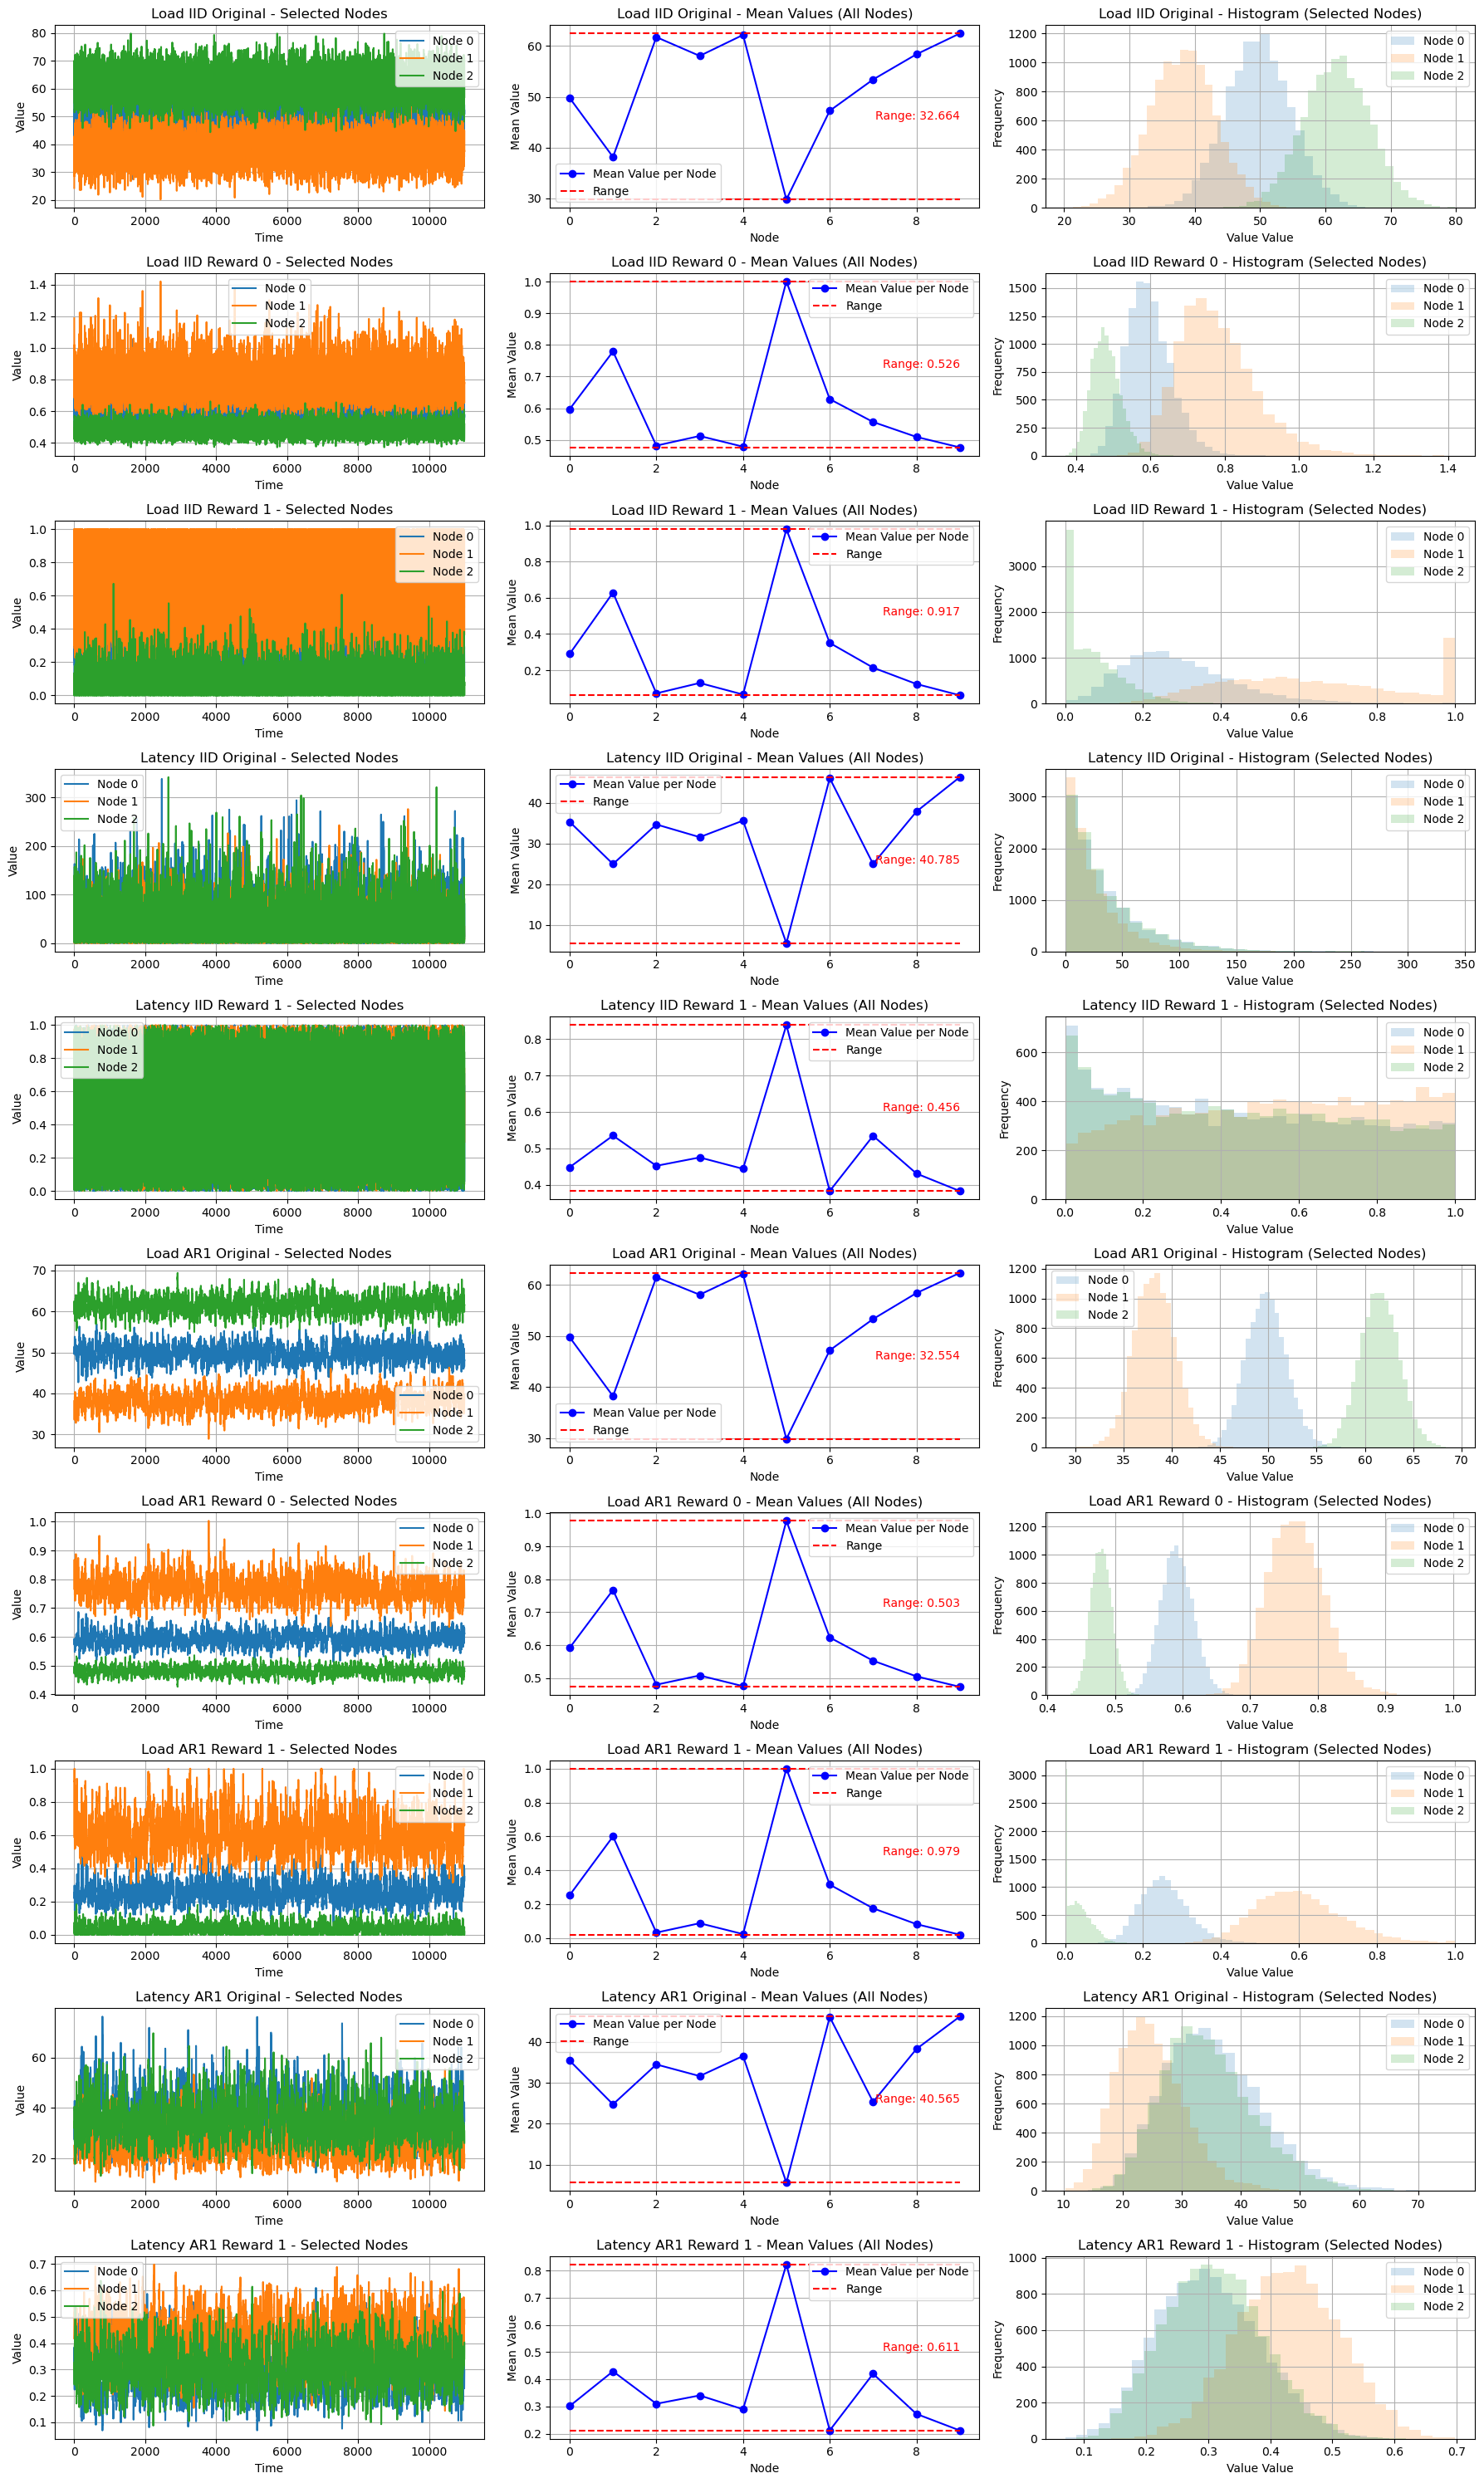

In [3]:
# 加载数据
reward_data_manager = DataInit.import_data_manager(models_pkl_path, 'reward', if_print=True)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import re
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.stats import norm
from typing import Generator

In [5]:
from scipy.ndimage import gaussian_filter1d
def moving_average(data, window_size=50):
    """简单滑动平均平滑"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def exponential_moving_average(data, alpha=0.01):
    """指数加权平均平滑"""
    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]
    for t in range(1, len(data)):
        smoothed_data[t] = alpha * data[t] + (1 - alpha) * smoothed_data[t-1]
    return smoothed_data

def gaussian_smooth(data, sigma=15):
    """高斯平滑"""
    return gaussian_filter1d(data, sigma=sigma)

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, widgets, HBox, VBox, Output, interactive_output, interactive, GridBox, Layout
from IPython.display import display
import matplotlib.gridspec as gridspec

In [7]:
class MAB:
    def __init__(self, config, reward_data_manager, exp4_data_manager):
        self.config: DictConfig = config
        self.reward_data_manager: RewardDataManager = reward_data_manager

        # 初始化通用参数
        self.lambda_load: float = self.config.base.lambda_load
        self.top_k: list[int] = self.config.base.top_k
        self.N: int = self.config.base.N
        self.T_test: int = self.config.base.T_test

        # 加载数据
        self.iid_load: np.ndarray = reward_data_manager.iid_load
        self.iid_load_reward_0: np.ndarray = reward_data_manager.iid_load_reward_0
        self.iid_load_reward_1: np.ndarray = reward_data_manager.iid_load_reward_1
        self.iid_latency: np.ndarray = reward_data_manager.iid_latency
        self.iid_latency_reward_1: np.ndarray = reward_data_manager.iid_latency_reward_1
        self.ar1_load: np.ndarray = reward_data_manager.ar1_load
        self.ar1_load_reward_0: np.ndarray = reward_data_manager.ar1_load_reward_0
        self.ar1_load_reward_1: np.ndarray = reward_data_manager.ar1_load_reward_1
        self.ar1_latency: np.ndarray = reward_data_manager.ar1_latency
        self.ar1_latency_reward_1: np.ndarray = reward_data_manager.ar1_latency_reward_1
        
        # Exp4 算法 专家系统数据
        self.exp4_data_manager = exp4_data_manager

        # 定义一个映射字典
        self.reward_mapping: dict[tuple[str, str], tuple[np.ndarray, np.ndarray]] = {
            ('iid', 'reward_0'): (self.iid_load_reward_0, self.iid_latency_reward_1),
            ('iid', 'reward_1'): (self.iid_load_reward_1, self.iid_latency_reward_1),
            ('ar1', 'reward_0'): (self.ar1_load_reward_0, self.ar1_latency_reward_1),
            ('ar1', 'reward_1'): (self.ar1_load_reward_1, self.ar1_latency_reward_1),
        }
        
        self.load_reward_method: str | None = None
        self.data_type: str | None = None
        self.load_reward: np.ndarray | None = None
        self.latency_reward: np.ndarray | None = None
        self.combine_reward: np.ndarray | None = None
        self.combine_reward_mean: np.ndarray | None = None
        self.combine_reward_optimal_node: int | None = None
        self.combine_reward_optimal_mean: float | None = None
        self.combine_reward_sorted_mean: np.ndarray | None = None
        
        self.algorithm: MAB.EpsilonGreedy | MAB.AdaptiveEpsilonGreedy | MAB.DynamicAdaptiveEpsilonGreedy | MAB.Boltzmann | MAB.UCB | MAB.ThompsonSampling | MAB.Exp3 | MAB.ExpIx | MAB.EXP4 | None = None

        # 生成器对象，用于断点执行
        # self.exp4_gen: Generator[None, None, None] | None = None
        # self.exp4_executed = False  # 用于控制 exp4_generator 只执行一次
        
        # self.select_exp4_counts: int = 0  # 用于记录调取EXP4算法的次数，用于判断重新运算combine rewards

    def set_parameters(self, load_reward_method: str, data_type: str) -> None:
        """
        设置参数并计算组合奖励。
        :param load_reward_method: 加载奖励的方法，'reward_0' 或 'reward_1'
        :param data_type: 数据类型，'iid' 或 'ar1'
        """
        # 重新设置参数
        self.load_reward_method = load_reward_method
        self.data_type = data_type
        try:
            self.load_reward, self.latency_reward = self.reward_mapping[(data_type, load_reward_method)]
        except KeyError:
            raise ValueError(f'Invalid load_reward_method: {load_reward_method}, data_type: {data_type}')

        # 计算组合奖励
        self.combine_reward = self.lambda_load * self.load_reward + (1 - self.lambda_load) * self.latency_reward
        self.combine_reward_mean = np.mean(self.combine_reward, axis=1)
        self.combine_reward_optimal_node = np.argmax(self.combine_reward_mean)
        self.combine_reward_optimal_mean = np.max(self.combine_reward_mean)
        self.combine_reward_sorted_mean = np.argsort(self.combine_reward_mean)[::-1]

        
        self.exp4_data_manager.ar_data.set_parameters(load_reward_method, data_type)
        self.exp4_data_manager.lstm_data.set_parameters(load_reward_method, data_type)
        self.exp4_data_manager.gnn_data.set_parameters(load_reward_method, data_type)

        # def exp4_generator() -> Generator[None, None, None]:
        #     # 在Exp4专家模型数据管理器中，也选择相应方法计算好相应的reward_combine值，以待备用
        # 
        #     # 生成器的第一个部分
        #     yield  # 暂停执行，等待选择到EXP4算法时，调用next()继续
        # 
        #     # 生成器的第二部分
        #     # exp4相关的代码在这里    
        #     self.exp4_data_manager.ar_data.set_parameters(data_type, load_reward_method)
        #     self.exp4_data_manager.lstm_data.set_parameters(data_type, load_reward_method)
        #     self.exp4_data_manager.gnn_data.set_parameters(data_type, load_reward_method)
        #     # 生成器的结束
        # 
        # self.exp4_gen: Generator[None, None, None] = self.exp4_generator()
        # # 当 exp4_generator() 被调用时，生成器并不会立即执行，而是返回一个生成器对象。此时，生成器还未开始执行。
        # # 第一个 None 表示生成器 yield 语句产生的值的类型。在你的例子中，没有 yield 产生的值，所以是 None。
        # # 第二个 None 表示生成器接收 send() 方法发送的值的类型。你没有使用 send()，所以是 None。
        # # 第三个 None 表示生成器函数最终返回的值的类型。通常，生成器不会返回值，或者返回 None。
        

    def calculate_top_k_accuracy(self, time_counts: np.ndarray, k_list: list[int]) -> dict[int, float]:
        """
        计算 MAB 过程的 Top-k Accuracy（定义二）。
        
        参数:
        - time_counts: 一个数组，表示在每个时间步中选择的节点。
        - k_list: 一个整数列表，表示需要计算的 k 值。
        
        返回:
        - 一个字典，key 是 k 的值，value 是对应的 Top-k Accuracy。
        
        说明:
        - Top-k Accuracy 的定义二：在 T_test 个时间步中，选择的节点中有多少是最优节点的前 k 个节点。
        """
        
        top_k_accuracy: dict[int, float] = {}

        for k in k_list:
            correct_count: int = 0
            optimal_nodes: np.ndarray = self.combine_reward_sorted_mean[:k]
            
            for t in range(self.T_test):
                if time_counts[t] in optimal_nodes:
                    correct_count += 1
            accuracy: float = correct_count / self.T_test
            top_k_accuracy[k] = accuracy

        return top_k_accuracy

    def plot_combine_rewards(self, selected_nodes: list[int] | None = None) -> None:
        """
        绘制组合奖励的图形。
        
        参数:
        - selected_nodes: 一个列表，表示选择的节点的索引。默认为 None，表示选择前 3 个节点。
        
        说明:
        - 组合奖励是加载奖励和延迟奖励的加权和。
        """
        
        if selected_nodes is None:
            selected_nodes: list[int] = [0, 1, 2]  # 默认选择前3个节点
    
        # 数据准备
        last_T_data: np.ndarray = self.combine_reward[selected_nodes, -self.T_test:]
    
        # 使用 constrained_layout 进行更智能的布局管理
        fig, axs = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)
    
        # 1. combine_reward中选择节点的最后T_test次数据的展示
        for i, node in enumerate(selected_nodes):
            axs[0].plot(last_T_data[i], label=f'Node {node}')
        axs[0].set_title('Last T_test Data - Selected Nodes')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Value')
        axs[0].legend()
    
        # 2. N个节点的均值的分布图，并标注最值
        means: np.ndarray = self.combine_reward_mean
        axs[1].plot(means, 'bo-', label='Mean Value per Node')
        axs[1].axhline(y=np.min(means), color='red', linestyle='--', label='Range')
        axs[1].axhline(y=np.max(means), color='red', linestyle='--')
        axs[1].set_title('Mean Values of Nodes')
        axs[1].set_xlabel('Node')
        axs[1].set_ylabel('Mean Value')
        axs[1].legend()
        
        # 调整标注的位置，避免超出图形范围
        axs[1].annotate(f'Min: {np.min(means):.3f}', xy=(np.argmin(means), np.min(means)), 
                        xytext=(np.argmin(means) + 0.5, np.min(means) - 0.05),
                        arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='black')
        axs[1].annotate(f'Max: {np.max(means):.3f}', xy=(np.argmax(means), np.max(means)), 
                        xytext=(np.argmax(means) + 0.5, np.max(means) + 0.05),
                        arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='black')
    
        # 3. 选择节点的最后T_test次数据的直方图
        for i, node in enumerate(selected_nodes):
            axs[2].hist(last_T_data[i], alpha=0.5, label=f'Node {node}')
        axs[2].set_title('Histogram - Selected Nodes')
        axs[2].set_xlabel('Value')
        axs[2].set_ylabel('Frequency')
        axs[2].legend()
    
        plt.show()
        
    class EpsilonGreedy:
        """
        Epsilon-Greedy 算法类。
        这是最初级的多臂老虎机算法，根据 epsilon 的值以一定概率随机选择节点，以 1-epsilon 的概率选择当前平均奖励最高的节点。
        
        func:
        - algorithm: 运行 epsilon-greedy 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
        - plot_results: 绘制 epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾以及 Top-k Accuracy，并应用平滑。
        - plot_evaluation: 绘制累积遗憾、Top-k Accuracy 和 epsilon 的关系图。
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_eg: DictConfig = self.mab.config.epsilon_greedy

            self.dynamic_epsilon_min: float = self.config_eg.dynamic_plot.epsilon_min  # 动态 epsilon 的最小值
            self.dynamic_epsilon_max: float = self.config_eg.dynamic_plot.epsilon_max  # 动态 epsilon 的最大值
            self.dynamic_epsilon_step: float = self.config_eg.dynamic_plot.epsilon_step  # 动态 epsilon 的步长
            self.dynamic_epsilon_default_value: float = self.config_eg.dynamic_plot.epsilon_default_value
            
            self.evaluation_epsilon_min: float = self.config_eg.evaluation.epsilon_min  # 评估 epsilon 的最小值
            self.evaluation_epsilon_max: float = self.config_eg.evaluation.epsilon_max  # 评估 epsilon 的最大值
            self.evaluation_epsilon_step: float = self.config_eg.evaluation.epsilon_step  # 评估 epsilon 的步长
            
        def algorithm(self, epsilon: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float]]:
            """
            运行 epsilon-greedy 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - epsilon: epsilon 的值，表示随机选择节点的概率。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            """
            def choose_node(epsilon: float, estimated_means: np.ndarray) -> np.signedinteger | int:
                if np.random.rand() < epsilon:
                    return np.random.randint(self.mab.N)
                else:
                    return np.argmax(estimated_means)

            estimated_means: np.ndarray = np.zeros(self.mab.N)
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)

            for t in range(self.mab.T_test):
                chosen_node: np.signedinteger | int = choose_node(epsilon, estimated_means)
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                reward: float = self.mab.combine_reward[chosen_node, t]
                estimated_means[chosen_node] += (reward - estimated_means[chosen_node]) / nodes_counts[chosen_node]
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict[int, float], epsilon: float) -> None:
            """
            绘制 epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾以及 Top-k Accuracy，并应用平滑。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy
            - epsilon: 当前实验使用的 epsilon 值。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig, axs = plt.subplots(2, 2, figsize=(14, 8))
            
            fig.suptitle(f"Epsilon-Greedy Results\nEpsilon: {epsilon}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            optimal_node: int = self.mab.combine_reward_optimal_node
            axs[0, 0].axhline(y=optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：单次遗憾的平滑曲线
            axs[0, 1].plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            axs[0, 1].set_title('Single Step Regret (Smoothed)')
            axs[0, 1].set_xlabel('Time Step')
            axs[0, 1].set_ylabel('Regret')

            # 标记最大值和最小值
            min_idx = np.argmin(smoothed_single_step_regret)
            axs[0, 1].annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                               xy=(min_idx, smoothed_single_step_regret[min_idx]),
                               xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                               arrowprops=dict(facecolor='blue', arrowstyle='->'),
                               fontsize=10, color='blue')

            max_idx = np.argmax(smoothed_single_step_regret)
            axs[0, 1].annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                               xy=(max_idx, smoothed_single_step_regret[max_idx]),
                               xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                               arrowprops=dict(facecolor='red', arrowstyle='->'),
                               fontsize=10, color='red')

            # 子图3：累积遗憾的平滑曲线
            axs[1, 0].plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')
            axs[1, 0].set_title('Cumulative Regret (Smoothed)')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('Cumulative Regret')

            # 标记最大值和最小值
            min_idx = np.argmin(smoothed_cumulative_regret)
            axs[1, 0].annotate(f'Min (x={min_idx}, y={smoothed_cumulative_regret[min_idx]:.2f})',
                               xy=(min_idx, smoothed_cumulative_regret[min_idx]),
                               xytext=(min_idx, smoothed_cumulative_regret[min_idx] + 0.05),
                               arrowprops=dict(facecolor='blue', arrowstyle='->'),
                               fontsize=10, color='blue')

            max_idx = np.argmax(smoothed_cumulative_regret)
            axs[1, 0].annotate(f'Max (x={max_idx}, y={smoothed_cumulative_regret[max_idx]:.2f})',
                               xy=(max_idx, smoothed_cumulative_regret[max_idx]),
                               xytext=(max_idx, smoothed_cumulative_regret[max_idx] - 0.05),
                               arrowprops=dict(facecolor='red', arrowstyle='->'),
                               fontsize=10, color='red')

            # 子图4：Top-k Accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95)) # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_evaluation(self) -> None:
            """
            绘制 epsilon vs cumulative regret 图和 epsilon vs top-k accuracy 图。
            """
            epsilon_values: np.ndarray = np.arange(self.evaluation_epsilon_min, self.evaluation_epsilon_max, self.evaluation_epsilon_step)
            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []
        
            for epsilon in epsilon_values:
                _, _, _, cumulative_regret, top_k_accuracy = self.algorithm(epsilon)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)
        
            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))
            
            fig.suptitle('Epsilon vs Cumulative Regret and Top-k Accuracy')
            
            # 绘制 epsilon vs cumulative regret 图
            axs[0].plot(epsilon_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Epsilon vs Cumulative Regret')
            axs[0].set_xlabel('Epsilon')
            axs[0].set_ylabel('Cumulative Regret')
            
            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={epsilon_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(epsilon_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(epsilon_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')
            
            axs[0].annotate(f'Max (x={epsilon_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(epsilon_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(epsilon_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(epsilon_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Epsilon')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_interactive(self, epsilon: float):
            """
            交互式绘制 epsilon-greedy 算法的结果。
            :param epsilon: 固定的全局 epsilon 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy = self.algorithm(epsilon)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, epsilon)

    class AdaptiveEpsilonGreedy:
        """
        Adaptive Epsilon-Greedy 算法类。
        在 Epsilon-Greedy 算法的基础上，根据时间步调整 epsilon 的值。
        越靠后，epsilon 越小，即 epsilon = 1 - t / T_test。
        但是为了保证 epsilon 不会小于最小值，因此设置了一个 min_epsilon 参数，表示算法中可以使用的最小 epsilon 值。
        原先的 epsilon greedy 算法中的 epsilon 在此算法中相当于初始值。
        
        func:
        - algorithm: 运行 adaptive epsilon-greedy 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
        - plot_results: 绘制 adaptive epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy 以及 epsilon 随时间的变化。
        - plot_evaluation: 绘制 epsilon vs cumulative regret 图和 epsilon vs top-k accuracy 图。
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_aeg: DictConfig = self.mab.config.adaptive_epsilon_greedy
        
            self.dynamic_init_epsilon_min: float = self.config_aeg.dynamic_plot.init_epsilon_min  # 动态图 epsilon 的最小值
            self.dynamic_init_epsilon_max: float = self.config_aeg.dynamic_plot.init_epsilon_max  # 动态图 epsilon 的最大值
            self.dynamic_init_epsilon_step: float = self.config_aeg.dynamic_plot.init_epsilon_step  # 动态图 epsilon 的步长
            self.dynamic_init_epsilon_default_value: float = self.config_aeg.dynamic_plot.init_epsilon_default_value  # 动态 epsilon 的默认值
        
            self.dynamic_min_epsilon_min: float = self.config_aeg.dynamic_plot.min_epsilon_min  # 动态图 min_epsilon 的最小值
            self.dynamic_min_epsilon_max: float = self.config_aeg.dynamic_plot.min_epsilon_max  # 动态图 min_epsilon 的最大值
            self.dynamic_min_epsilon_step: float = self.config_aeg.dynamic_plot.min_epsilon_step  # 动态图 min_epsilon 的步长
            self.dynamic_min_epsilon_default_value: float = self.config_aeg.dynamic_plot.min_epsilon_default_value  # 动态图 min_epsilon 的默认值
        
            self.eval_init_epsilon_min: float = self.config_aeg.evaluation.init_epsilon_min  # 评估图 init_epsilon 的最小值
            self.eval_init_epsilon_max: float = self.config_aeg.evaluation.init_epsilon_max  # 评估图 init_epsilon 的最大值
            self.eval_init_epsilon_step: float = self.config_aeg.evaluation.init_epsilon_step  # 评估图 init_epsilon 的步长
            self.eval_min_epsilon: float = self.config_aeg.evaluation.min_epsilon  # 评估图算法可取到的 epsilon 的最小值


        def algorithm(self, init_epsilon: float, min_epsilon: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray]:
            """
            运行 adaptive epsilon-greedy 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - init_epsilon: epsilon 的初始值，表示随机选择节点的概率。
            - min_epsilon: epsilon 的最小值，表示算法中可以使用的最小 epsilon 值。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - epsilon_time: 一个数组，表示每个时间步的 epsilon 值。
            """
            epsilon: float = init_epsilon
            def choose_node(epsilon: float, estimated_means: np.ndarray) -> int | np.signedinteger:
                if np.random.rand() < epsilon:
                    return np.random.randint(self.mab.N)
                else:
                    return np.argmax(estimated_means)

            estimated_means: np.ndarray = np.zeros(self.mab.N)
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)
            epsilon_time: np.ndarray = np.zeros(self.mab.T_test)

            for t in range(self.mab.T_test):
                epsilon = max(min_epsilon, epsilon * (1 - t / self.mab.T_test))
                epsilon_time[t] = epsilon
                chosen_node: int = choose_node(epsilon, estimated_means)
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                reward: float = self.mab.combine_reward[chosen_node, t]
                estimated_means[chosen_node] += (reward - estimated_means[chosen_node]) / nodes_counts[chosen_node]
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, epsilon_time

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, epsilon: float, epsilon_time: np.ndarray) -> None:
            """
            绘制 epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy，以及 epsilon 随时间的变化。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - epsilon: 当前实验使用的 epsilon 值。
            - epsilon_time: 一个数组，表示每个时间步的 epsilon 值（适用于 adaptive_epsilon_greedy）。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig, axs = plt.subplots(2, 2, figsize=(14, 8))

            fig.suptitle(f"Adaptive Epsilon-Greedy Results\nInitial Epsilon: {epsilon}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            optimal_node = self.mab.combine_reward_optimal_node
            axs[0, 0].axhline(y=optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1 = axs[0, 1]
            ax2 = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx = np.argmin(smoothed_single_step_regret)
            max_idx = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3：绘制 epsilon_time 随时间的变化
            axs[1, 0].plot(epsilon_time, marker='o', linestyle='-', color='purple')
            axs[1, 0].set_title('Epsilon over Time')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('Epsilon')

            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_evaluation(self) -> None:
            """
            绘制 epsilon vs cumulative regret 图和 epsilon vs top-k accuracy 图。
            """
            epsilon_values: np.ndarray = np.arange(self.eval_init_epsilon_min, self.eval_init_epsilon_max, self.eval_init_epsilon_step)
            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []

            for epsilon in epsilon_values:
                _, _, _, cumulative_regret, top_k_accuracy, _ = self.algorithm(epsilon, self.eval_min_epsilon)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)

            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))

            fig.suptitle(f'Init Epsilon vs Cumulative Regret with fixed Min Epsilon: {self.eval_min_epsilon} and Top-k Accuracy')

            # 绘制 epsilon vs cumulative regret 图
            axs[0].plot(epsilon_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Epsilon vs Cumulative Regret')
            axs[0].set_xlabel('Epsilon')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={epsilon_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(epsilon_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(epsilon_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={epsilon_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(epsilon_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(epsilon_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(epsilon_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Epsilon')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_interactive(self, init_epsilon: float, min_epsilon: float):
            """
            交互式绘制 adaptive epsilon-greedy 算法的结果。
            :param init_epsilon: 初始 epsilon 值
            :param min_epsilon: 最小 epsilon 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, epsilon_time = self.algorithm(init_epsilon, min_epsilon)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, init_epsilon, epsilon_time)

    class DynamicAdaptiveEpsilonGreedy:
        """
        Dynamic Adaptive Epsilon-Greedy 算法类。
        在Adaptive Epsilon-Greedy算法的基础上，根据单步遗憾调整epsilon。
        
        最初是手动设置阈值，当单步遗憾超过阈值时，增加epsilon，否则减小epsilon。
        但是这种方法不够灵活，因此改为根据单步遗憾的百分位数调整epsilon。
        
        最初始的变化幅度是init_alpha * 上一次的单步遗憾）
        当前使用的变化幅度是遗憾值与阈值之间的差距，归一化处理后的相对位置。
        
        func:
        - algorithm: 运行 dynamic adaptive epsilon-greedy 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
        - plot_results: 绘制 dynamic adaptive epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy 以及 epsilon 随时间的变化。
        - plot_evaluation: 绘制 epsilon vs cumulative regret 图。
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_daeg: DictConfig = self.mab.config.dynamic_adaptive_epsilon_greedy
    
            self.min_epsilon: float = self.config_daeg.min_epsilon  # 最小 epsilon 值
            self.max_epsilon: float = self.config_daeg.max_epsilon  # 最大 epsilon 值
    
            self.dynamic_init_epsilon_min: float = self.config_daeg.dynamic_plot.init_epsilon_min  # 动态 epsilon 的最小值
            self.dynamic_init_epsilon_max: float = self.config_daeg.dynamic_plot.init_epsilon_max  # 动态 epsilon 的最大值
            self.dynamic_init_epsilon_step: float = self.config_daeg.dynamic_plot.init_epsilon_step  # 动态 epsilon 的步长
            self.dynamic_init_epsilon_default_value: float = self.config_daeg.dynamic_plot.init_epsilon_default_value  # 动态 epsilon 的默认值
    
            self.dynamic_percentiles_min: float = self.config_daeg.dynamic_plot.percentiles_min  # 动态 percentiles 的最小值
            self.dynamic_percentiles_max: float = self.config_daeg.dynamic_plot.percentiles_max  # 动态 percentiles 的最大值
            self.dynamic_percentiles_step: float = self.config_daeg.dynamic_plot.percentiles_step  # 动态 percentiles 的步长
            self.dynamic_percentiles_default_value: float = self.config_daeg.dynamic_plot.percentiles_default_value  # 动态 percentiles 的默认值
    
            self.evaluation_init_epsilon_min: float = self.config_daeg.evaluation.init_epsilon_min  # 评估图 init_epsilon 的最小值
            self.evaluation_init_epsilon_max: float = self.config_daeg.evaluation.init_epsilon_max  # 评估图 init_epsilon 的最大值
            self.evaluation_init_epsilon_step: float = self.config_daeg.evaluation.init_epsilon_step # 评估图 init_epsilon 的步长
            self.evaluation_default_percentiles: float = self.config_daeg.evaluation.default_percentiles  # 评估图的百分位数
            
            self.evaluation_percentiles_min: float = self.config_daeg.evaluation.percentiles_min  # 评估图 percentiles 的最小值
            self.evaluation_percentiles_max: float = self.config_daeg.evaluation.percentiles_max  # 评估图 percentiles 的最大值
            self.evaluation_percentiles_step: float = self.config_daeg.evaluation.percentiles_step  # 评估图 percentiles 的步长
            self.evaluation_default_init_epsilon: float = self.config_daeg.evaluation.default_init_epsilon
            
        def algorithm(self, init_epsilon: float, percentiles: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray]:
            """
            运行 dynamic adaptive epsilon-greedy 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - init_epsilon: epsilon 的初始值，表示随机选择节点的概率。
            - percentiles: 百分位数，用于计算遗憾值的阈值。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - epsilon_time: 一个数组，表示每个时间步的 epsilon 值。
            """
            
            epsilon: float = init_epsilon
            def choose_node(epsilon, estimated_means):
                if np.random.rand() < epsilon:
                    return np.random.randint(self.mab.N)
                else:
                    return np.argmax(estimated_means)

            estimated_means: np.ndarray = np.zeros(self.mab.N)
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)
            epsilon_time: np.ndarray = np.zeros(self.mab.T_test)

            for t in range(self.mab.T_test):
                if t > 0: # 如果 t > 0，则根据单步遗憾调整epsilon，计算百分位数
                    threshold: float = np.percentile(single_step_regret[:t], percentiles)
                    if single_step_regret[t - 1] > threshold:
                        # 如果单步遗憾值超过了阈值，计算遗憾值与阈值之间的差距，并进行归一化处理。归一化的计算方法是将差值除以阈值（加上一个非常小的值 1e−6，以防止分母为零）。
                        # 归一化的结果 adjustment 会是一个相对值，用来调整 epsilon。这个值越大，说明当前的遗憾值相对于阈值越大，调整的幅度也就越大。
                        adjustment: float = float(single_step_regret[t - 1] - threshold) / (threshold + 1e-6)  # 归一化的相对位置
                        # 当前遗憾值超过阈值的情况下，通过增加 epsilon 的值来增强探索的力度
                        epsilon = min(self.max_epsilon, epsilon + adjustment)
                    else:
                        # 如果当前的单步遗憾没有超过阈值，说明当前的动作表现相对较好，因此倾向于减少探索，更多地利用当前的策略。
                        adjustment: float = float(threshold - single_step_regret[t - 1]) / (threshold + 1e-6)
                        epsilon = max(self.min_epsilon, epsilon - adjustment)
                else:
                    # 如果 t == 0，则不计算百分位数，直接使用初始 epsilon
                    epsilon_time[t] = epsilon

                epsilon_time[t] = epsilon
                chosen_node: int = choose_node(epsilon, estimated_means)
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                reward: float = self.mab.combine_reward[chosen_node, t]
                estimated_means[chosen_node] += (reward - estimated_means[chosen_node]) / nodes_counts[chosen_node]
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, epsilon_time

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, epsilon: float, epsilon_time: np.ndarray) -> None:
            """
            绘制 epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy，以及 epsilon 随时间的变化。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - epsilon: 当前实验使用的 epsilon 值。
            - epsilon_time: 一个数组，表示每个时间步的 epsilon 值（适用于 adaptive_epsilon_greedy）。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig, axs = plt.subplots(2, 2, figsize=(14, 8))

            fig.suptitle(f"Dynamically Adaptive Epsilon-Greedy Results\nInitial Epsilon: {epsilon}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            axs[0, 0].axhline(y=self.mab.combine_reward_optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1 = axs[0, 1]
            ax2 = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx = np.argmin(smoothed_single_step_regret)
            max_idx = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3：绘制 epsilon_time 随时间的变化
            axs[1, 0].plot(epsilon_time, marker='o', linestyle='-', color='purple')
            axs[1, 0].set_title('Epsilon over Time')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('Epsilon')

            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_evaluation(self, hyperparameters: str) -> None:
            """
            绘制 epsilon vs cumulative regret 图 和 epsilon vs top-k accuracy 图。
            """
            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []
            
            if hyperparameters == 'init_epsilon':
                epsilon_values: np.ndarray = np.arange(self.evaluation_init_epsilon_min, self.evaluation_init_epsilon_max, self.evaluation_init_epsilon_step)
                fixed_percentiles: float = self.evaluation_default_percentiles
    
                for epsilon in epsilon_values:
                    _, _, _, cumulative_regret, top_k_accuracy, _ = self.algorithm(epsilon, fixed_percentiles)
                    cumulative_regrets.append(cumulative_regret[-1])
                    time_top_k_accuracy.append(top_k_accuracy)

            elif hyperparameters == 'percentiles':
                fixed_epsion = self.evaluation_default_init_epsilon
                percentiles_values: np.ndarray = np.arange(self.evaluation_percentiles_min, self.evaluation_percentiles_max, self.evaluation_percentiles_step)
                for percentiles in percentiles_values:
                    _, _, _, cumulative_regret, top_k_accuracy, _ = self.algorithm(fixed_epsion, percentiles)
                    cumulative_regrets.append(cumulative_regret[-1])
                    time_top_k_accuracy.append(top_k_accuracy)
                    

            
            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))
            
            if hyperparameters == 'init_epsilon':
                fig.suptitle(f'Init Epsilon vs Cumulative Regret with fixed Percentiles: {self.evaluation_default_percentiles} and Top-k Accuracy')
                plot_values = epsilon_values
                
            elif hyperparameters == 'percentiles':
                fig.suptitle(f'Percentiles vs Cumulative Regret with fixed Init Epsilon: {self.evaluation_default_init_epsilon} and Top-k Accuracy')
                plot_values = percentiles_values

            
            # 绘制 percentiles vs cumulative regret 图
            axs[0].plot(plot_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Epsilon vs Cumulative Regret')
            axs[0].set_xlabel('Epsilon')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={plot_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(plot_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(plot_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={plot_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(plot_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(plot_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(plot_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                if hyperparameters == 'init_epsilon':
                    axs[i+1].set_xlabel('Epsilon')
                elif hyperparameters == 'percentiles':
                    axs[i+1].set_xlabel('Percentiles')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_interactive(self, init_epsilon: float, percentiles: float):
            """
            交互式绘制 dynamic adaptive epsilon-greedy 算法的结果。
            :param init_epsilon: 初始 epsilon 值
            :param percentiles: 百分位数
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, epsilon_time = self.algorithm(init_epsilon, percentiles)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, init_epsilon, epsilon_time)

    class Boltzmann:
        """
        Boltzmann 算法类。
        Boltzmann策略基于每个动作的预期奖励（estimated mean）来计算一个概率分布，然后根据这个概率分布选择动作。这个概率分布由每个动作的预期奖励通过温度参数（temperature）调节后得到的软最大值（Softmax函数）确定。
        控制参数为温度。当温度较高时，算法的选择更随机，倾向于探索；当温度较低时，算法更倾向于选择当前已知的最优动作（利用）。
        当温度 τ 很低时，Softmax 函数倾向于将选择概率集中在奖励最高的动作上，类似于贪心策略。
        随着温度 τ 的升高，选择概率变得更加均匀，Softmax 函数逐渐接近于随机选择。
        适用场景：Boltzmann策略在奖励分布相对稳定、噪声较小的场景中表现较好，因为它可以根据已知信息较为精确地调整选择概率。
        
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_boltzmann: DictConfig = self.mab.config.boltzmann

            self.dynamic_temperature_min: float = self.config_boltzmann.dynamic_plot.temperature_min  # 动态 temperature 的最小值
            self.dynamic_temperature_max: float = self.config_boltzmann.dynamic_plot.temperature_max  # 动态 temperature 的最大值
            self.dynamic_temperature_step: float = self.config_boltzmann.dynamic_plot.temperature_step  # 动态 temperature 的步长
            self.dynamic_temperature_default_value: float = self.config_boltzmann.dynamic_plot.temperature_default_value  # 动态 temperature 的默认值
    
            self.evaluation_temperature_min: float = self.config_boltzmann.evaluation.temperature_min  # 评估图 temperature 的最小值
            self.evaluation_temperature_max: float = self.config_boltzmann.evaluation.temperature_max  # 评估图 temperature 的最大值
            self.evaluation_temperature_step: float = self.config_boltzmann.evaluation.temperature_step  # 评估图 temperature 的步长

        def algorithm(self, temperature: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray]:
            """
            运行 Boltzmann 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - temperature: 温度值，用于调节选择概率。它控制了选择动作的随机性，温度越高，选择越随机，温度越低，选择越倾向于最优动作。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            """
            def choose_node(temperature: float, estimated_means: np.ndarray) -> tuple[int, np.ndarray]:
                exp_values: np.ndarray = np.exp(estimated_means / temperature)
                probabilities: np.ndarray = exp_values / np.sum(exp_values)
                return np.random.choice(self.mab.N, p=probabilities), probabilities

            estimated_means: np.ndarray = np.zeros(self.mab.N)
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)
            time_probabilities: np.ndarray = np.zeros((self.mab.T_test, self.mab.N))
        
            for t in range(self.mab.T_test):
                chosen_node, probabilities = choose_node(temperature, estimated_means)
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                time_probabilities[t] = probabilities
                reward: float = self.mab.combine_reward[chosen_node, t]
                estimated_means[chosen_node] += (reward - estimated_means[chosen_node]) / nodes_counts[chosen_node]
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, temperature: float, temperature_time_probabilities: np.ndarray) -> None:
            """
            绘制 epsilon-greedy 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy，以及 epsilon 随时间的变化。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - temperature: 当前实验使用的温度值。
            - temperature_time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig, axs = plt.subplots(2, 2, figsize=(14, 8))
            
            fig.suptitle(f"Boltzmann Results\nTemperature: {temperature}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            axs[0, 0].axhline(y=self.mab.combine_reward_optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1 = axs[0, 1]
            ax2 = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx = np.argmin(smoothed_single_step_regret)
            max_idx = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3：绘制 temperature_time_probabilities 随时间的变化
            for i in range(self.mab.N):
                axs[1, 0].plot(temperature_time_probabilities[:, i], marker='o', linestyle='-', label=f'Node {i}')
            axs[1, 0].set_title('Node Selection Probabilities Over Time')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('Probability')
            axs[1, 0].legend()
            
            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_evaluation(self) -> None:
            """
            绘制 temperature vs cumulative regret 图 和 temperature vs top-k accuracy 图。
            """
            temperature_values: np.ndarray = np.arange(self.evaluation_temperature_min, self.evaluation_temperature_max, self.evaluation_temperature_step)

            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []

            for temperature in temperature_values:
                _, _, _, cumulative_regret, top_k_accuracy, _ = self.algorithm(temperature)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)

            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))

            fig.suptitle('Temperature vs Cumulative Regret and Top-k Accuracy')

            # 绘制 epsilon vs cumulative regret 图
            axs[0].plot(temperature_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Temperature vs Cumulative Regret')
            axs[0].set_xlabel('Temperature')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={temperature_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(temperature_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(temperature_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={temperature_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(temperature_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(temperature_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(temperature_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Temperature')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_interactive(self, temperature: float) -> None:
            """
            交互式绘制 Boltzmann 算法的结果。
            :param temperature: 固定的全局 temperature 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities = self.algorithm(temperature)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, temperature, time_probabilities)
            
    class UCB:
        """
        UCB 算法类。
        UCB 算法是一种基于置信上界的多臂赌博机算法，通过计算每个动作的置信上界来选择动作。
        UCB 算法的核心思想是：在每个时间步 t，选择使得置信上界最大的动作。
        置信上界的计算方法是：动作的平均奖励 + 置信区间（置信区间的计算方法是置信上界的上限减去置信上界的下限）。
        控制参数为置信区间的参数 c。
        适用场景：UCB 算法在奖励分布相对稳定、噪声较小的场景中表现较好，因为它可以根据已知信息较为精确地调整选择概率。
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_ucb: DictConfig = self.mab.config.ucb

            self.dynamic_c_min: float = self.config_ucb.dynamic_plot.c_min  # 动态 c 的最小值
            self.dynamic_c_max: float = self.config_ucb.dynamic_plot.c_max  # 动态 c 的最大值
            self.dynamic_c_step: float = self.config_ucb.dynamic_plot.c_step  # 动态 c 的步长
            self.dynamic_c_default_value: float = self.config_ucb.dynamic_plot.c_default_value  # 动态 c 的默认值
    
            self.evaluation_c_min: float = self.config_ucb.evaluation.c_min  # 评估图 c 的最小值
            self.evaluation_c_max: float = self.config_ucb.evaluation.c_max  # 评估图 c 的最大值
            self.evaluation_c_step: float = self.config_ucb.evaluation.c_step  # 评估图 c 的步长

        def algorithm(self, c: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray]:
            """
            运行 UCB 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - c: 置信区间的参数。它控制置信区间的宽度，进而影响探索和利用之间的平衡。较大的 c 值会增加置信区间的宽度，使得算法更加倾向于探索；较小的 c 值会缩小置信区间，使得算法更加倾向于利用当前已知的最优选择。简单来说，c 值决定了算法在选择过程中对不确定性（即未被充分探索的选项）的容忍度。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - time_ucb_values: 一个二维数组，表示每个时间步的节点的 UCB 值, 即上置信界值。
            """
            estimated_means: np.ndarray = np.zeros(self.mab.N)
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)
            time_ucb_values: np.ndarray = np.zeros((self.mab.T_test, self.mab.N))

            for t in range(self.mab.T_test):
                ucb_values = estimated_means + c * np.sqrt(np.log(t + 1) / (nodes_counts + 1e-6))
                time_ucb_values[t] = ucb_values
                chosen_node: int = np.argmax(ucb_values)
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                reward: float = self.mab.combine_reward[chosen_node, t]
                estimated_means[chosen_node] += (reward - estimated_means[chosen_node]) / nodes_counts[chosen_node]
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_ucb_values
        
        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, c: float, time_ucb_values: np.ndarray) -> None:
            """
            绘制 UCB 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - c: 当前实验使用的 c 值。
            - time_ucb_values: 一个二维数组，表示每个时间步的节点的 UCB 值
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig, axs = plt.subplots(2, 2, figsize=(14, 8))

            fig.suptitle(f"UCB Results\nConfidence Interval Parameter: {c}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            axs[0, 0].axhline(y=self.mab.combine_reward_optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1 = axs[0, 1]
            ax2 = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx: np.signedinteger = np.argmin(smoothed_single_step_regret)
            max_idx: np.signedinteger = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3：绘制 time_ucb_values 随时间的变化
            for i in range(self.mab.N):
                axs[1, 0].plot(time_ucb_values[:, i], marker='o', linestyle='-', label=f'Node {i}')
            axs[1, 0].set_title('UCB Values Over Time')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('UCB Value')
            axs[1, 0].legend()
            
            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_evaluation(self) -> None:
            """
            绘制 confidence interval parameter vs cumulative regret 图 和 confidence interval parameter vs top-k accuracy 图。
            """
            c_values: np.ndarray = np.arange(self.evaluation_c_min, self.evaluation_c_max, self.evaluation_c_step)

            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []

            for c in c_values:
                _, _, _, cumulative_regret, top_k_accuracy, _ = self.algorithm(c)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)

            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))

            fig.suptitle('UCB Confidence Interval Parameter vs Cumulative Regret and Top-k Accuracy')

            # 绘制 confidence interval parameter vs cumulative regret 图
            axs[0].plot(c_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Confidence Interval Parameter vs Cumulative Regret')
            axs[0].set_xlabel('Confidence Interval Parameter')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={c_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(c_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(c_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={c_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(c_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(c_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(c_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Confidence Interval Parameter')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_interactive(self, c: float):
            """
            交互式绘制 UCB 算法的结果。
            :param c: 固定的全局 c 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_ucb_values = self.algorithm(c)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, c, time_ucb_values)
            
    class ThompsonSampling:
        """
        Thompson Sampling 算法类。
        Thompson Sampling 算法是一种基于贝叶斯推断的多臂赌博机算法，通过采样每个动作的奖励分布来选择动作。
        Thompson Sampling 算法的核心思想是：在每个时间步 t，对每个动作采样一个奖励，然后选择使得采样奖励最大的动作。
        采样奖励的计算方法是：对每个动作的奖励分布进行采样，然后选择采样值最大的动作。
        控制参数为采样次数 T。
        适用场景：Thompson Sampling 算法在奖励分布相对不稳定、噪声较大的场景中表现较好，因为它可以通过采样奖励分布来调整选择概率。
        """
        def __init__(self, mab):
            self.mab: MAB = mab

        def algorithm(self, distribution_method: str) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray]:
            """
            运行 Thompson Sampling 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - distribution_method: 选择奖励分布的方法。可以选择：
                - 'bernoulli': 伯努利分布, 适用于二元奖励, 例如点击率。
                - 'normal': 正态分布, 适用于连续奖励, 例如收入。
                - 'gamma': Gamma 分布, 适用于非负连续奖励, 例如转化率。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            """
            if distribution_method == 'bernoulli':
                alpha = np.ones(self.mab.N)  # 成功次数初始化为 1
                beta = np.ones(self.mab.N)  # 失败次数初始化为 1
                
            elif distribution_method == 'normal':
                mu = np.zeros(self.mab.N)  # 每个节点的均值估计初始化为 0
                sigma2 = np.ones(self.mab.N)  # 每个节点的方差初始化为 1
                
            elif distribution_method == 'gamma':
                shape = np.ones(self.mab.N)  # Gamma 分布的形状参数
                rate = np.ones(self.mab.N)  # Gamma 分布的速率参数
                
            time_counts = np.zeros(self.mab.T_test)
            nodes_counts = np.zeros(self.mab.N)
            single_step_regret = np.zeros(self.mab.T_test)
            time_theta = np.zeros((self.mab.T_test, self.mab.N))
        
            for t in range(self.mab.T_test):
                if distribution_method == 'bernoulli':
                    theta = np.random.beta(alpha, beta)  # 从 Beta 分布中采样
                    chosen_node = np.argmax(theta)  # 选择使得采样值最大的节点
                    nodes_counts[chosen_node] += 1  # 更新选择次数
                    # 获取奖励
                    reward = self.mab.combine_reward[chosen_node, t]
                    # 更新 alpha 和 beta
                    if reward == 1:
                        alpha[chosen_node] += 1
                    else:
                        beta[chosen_node] += 1
        
                elif distribution_method == 'normal':
                    theta = np.random.normal(mu, np.sqrt(sigma2))  # 从正态分布中采样
                    chosen_node = np.argmax(theta)  # 选择使得采样值最大的节点
                    # 获取奖励
                    reward = self.mab.combine_reward[chosen_node, t]
                    # 更新均值和方差
                    nodes_counts[chosen_node] += 1
                    mu[chosen_node] = (mu[chosen_node] * (nodes_counts[chosen_node] - 1) + reward) / nodes_counts[chosen_node]
                    sigma2[chosen_node] = 1 / nodes_counts[chosen_node]  # 方差随选择次数的增加而减小
                    
                    
                elif distribution_method == 'gamma':
                    theta = np.random.gamma(shape, 1/rate)  # 从 Gamma 分布中采样
                    chosen_node = np.argmax(theta)  # 选择使得采样值最大的节点
                    # 获取奖励
                    reward = self.mab.combine_reward[chosen_node, t]
                    # 更新 shape 和 rate
                    nodes_counts[chosen_node] += 1
                    shape[chosen_node] += reward
                    rate[chosen_node] += 1
                
                time_theta[t] = theta
                time_counts[t] = chosen_node
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward
        
            cumulative_regret = np.cumsum(single_step_regret)
            top_k_accuracy = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
        
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_theta

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, time_theta: np.ndarray) -> None:
            """
            绘制 Thompson Sampling 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - time_theta: 一个二维数组，表示每个时间步的节点的 theta 值。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig, axs = plt.subplots(2, 2, figsize=(14, 8))

            fig.suptitle(f"Thompson Sampling Results\nLoad Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            optimal_node = self.mab.combine_reward_optimal_node
            axs[0, 0].axhline(y=optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1: plt.Axes = axs[0, 1]
            ax2: plt.Axes = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx = np.argmin(smoothed_single_step_regret)
            max_idx = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3: 绘制 time_theta 随时间的变化
            for i in range(self.mab.N):
                axs[1, 0].plot(time_theta[:, i], marker='o', linestyle='-', label=f'Node {i}')
            axs[1, 0].set_title('Theta Values Over Time')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('Theta Value')
            axs[1, 0].legend()

            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
        
        def plot_interactive(self, distribution_method: str):
            """
            交互式绘制 Thompson Sampling 算法的结果。
            :param distribution_method: 选择奖励分布的方法
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_theta = self.algorithm(distribution_method)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_theta)
            
    class Exp3:
        """
        Exp3 算法类。
        Exp3 算法是一种基于概率的多臂赌博机算法，通过计算每个动作的概率分布来选择动作。
        Exp3 算法的核心思想是：在每个时间步 t，根据每个动作的权重计算概率分布，然后按照这个概率分布选择动作。
        算法的核心参数是学习率 eta。
        适用场景：Exp3 算法在奖励分布相对稳定、噪声较小的场景中表现较好，因为它可以根据已知信息较为精确地调整选择概率。
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_exp3: DictConfig = self.mab.config.exp3

            self.dynamic_gamma_min: float = self.config_exp3.dynamic_plot.gamma_min  # 动态 eta 的最小值
            self.dynamic_gamma_max: float = self.config_exp3.dynamic_plot.gamma_max  # 动态 eta 的最大值
            self.dynamic_gamma_step: float = self.config_exp3.dynamic_plot.gamma_step  # 动态 eta 的步长
            self.dynamic_gamma_default_value: float = self.config_exp3.dynamic_plot.gamma_default_value  # 动态 eta 的默认值
    
            self.evaluation_gamma_min: float = self.config_exp3.evaluation.gamma_min  # 评估图 eta 的最小值
            self.evaluation_gamma_max: float = self.config_exp3.evaluation.gamma_max  # 评估图 eta 的最大值
            self.evaluation_gamma_step: float = self.config_exp3.evaluation.gamma_step  # 评估图 eta 的步长


        def algorithm(self, gamma: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray]:
            """
            运行 Exp3 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - eta: 学习率。它控制了算法在选择过程中对不确定性（即未被充分探索的选项）的容忍度。较大的 eta 值会增加对不确定性的容忍度，使得算法更加倾向于探索；较小的 eta 值会减小对不确定性的容忍度，使得算法更加倾向于利用当前已知的最优选择。
            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            """
            weights: np.ndarray = np.ones(self.mab.N)
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)
            time_probabilities: np.ndarray = np.zeros((self.mab.T_test, self.mab.N))

            for t in range(self.mab.T_test):
                probabilities = (1 - gamma) * (weights / np.sum(weights)) + gamma / self.mab.N  # 计算概率分布
                chosen_node: int = np.random.choice(self.mab.N, p=probabilities)  # 根据概率分布选择节点
                reward = self.mab.combine_reward[chosen_node, t]  # 获取奖励
                estimates_reward: float = reward / probabilities[chosen_node]  # 计算奖励估计值
                weights[chosen_node] *= np.exp(gamma * estimates_reward / self.mab.N)  # 更新权重

                time_probabilities[t] = probabilities
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1                
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, gamma: float, time_probabilities: np.ndarray) -> None:
            """
            绘制 Exp3 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - eta: 当前实验使用的 eta 值。
            - time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)
    
            fig, axs = plt.subplots(2, 2, figsize=(14, 8))

            fig.suptitle(f"Exp3 Results\nGamma: {gamma}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            axs[0, 0].axhline(y=self.mab.combine_reward_optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1 = axs[0, 1]
            ax2 = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx: np.signedinteger = np.argmin(smoothed_single_step_regret)
            max_idx: np.signedinteger = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3: 绘制 time_probabilities 随时间的变化
            for i in range(self.mab.N):
                axs[1, 0].plot(time_probabilities[:, i], marker='o', linestyle='-', label=f'Node {i}')
            axs[1, 0].set_title('Node Selection Probabilities Over Time')
            axs[1, 0].set_xlabel('Time Step')
            axs[1, 0].set_ylabel('Probability')
            axs[1, 0].legend()

            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_evaluation(self) -> None:
            """
            绘制 eta vs cumulative regret 图 和 eta vs top-k accuracy 图。
            """
            gamma_values: np.ndarray = np.arange(self.evaluation_gamma_min, self.evaluation_gamma_max, self.evaluation_gamma_step)

            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []

            for gamma in gamma_values:
                _, _, _, cumulative_regret, top_k_accuracy, _ = self.algorithm(gamma)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)

            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))

            fig.suptitle('Exp3 Gamma vs Cumulative Regret and Top-k Accuracy')

            # 绘制 epsilon vs cumulative regret 图
            axs[0].plot(gamma_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Gamma vs Cumulative Regret')
            axs[0].set_xlabel('Gamma')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={gamma_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(gamma_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(gamma_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={gamma_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(gamma_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(gamma_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(gamma_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Gamma')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_interactive(self, gamma: float):
            """
            交互式绘制 Exp3 算法的结果。
            :param gamma: 固定的全局 eta 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities = self.algorithm(gamma)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, gamma, time_probabilities)
            
    class ExpIx:
        """
        Exp3-IX 算法类。
        Exp3-IX 算法是 Exp3 算法的一种变种，通过引入探索指数来增加对未知节点的探索。
        Exp3-IX 算法的核心思想是：在每个时间步 t，根据每个动作的权重计算概率分布，然后按照这个概率分布选择动作。
        算法的核心参数是学习率 eta 和探索指数 xi。
        适用场景：Exp3-IX 算法在奖励分布相对稳定、噪声较小的场景中表现较好，因为它可以根据已知信息较为精确地调整选择概率。
        """
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_exp_ix: DictConfig = self.mab.config.exp_ix
            
            self.dynamic_eta_min: float = self.config_exp_ix.dynamic_plot.eta_min  # 动态 eta 的最小值
            self.dynamic_eta_max: float = self.config_exp_ix.dynamic_plot.eta_max  # 动态 eta 的最大值
            self.dynamic_eta_step: float = self.config_exp_ix.dynamic_plot.eta_step  # 动态 eta 的步长
            self.dynamic_eta_default_value: float = self.config_exp_ix.dynamic_plot.eta_default_value  # 动态 eta 的默认值
            
            self.evaluation_eta_min: float = self.config_exp_ix.evaluation.eta_min  # 评估图 eta 的最小值
            self.evaluation_eta_max: float = self.config_exp_ix.evaluation.eta_max  # 评估图 eta 的最大值
            self.evaluation_eta_step: float = self.config_exp_ix.evaluation.eta_step  # 评估图 eta 的步长
            
            self.eta_method: str | None = None  # eta 的计算方法


        def algorithm(self, eta: float, eta_method: str) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict, np.ndarray, np.ndarray]:
            """
            运行 Exp3-IX 算法，返回选择的节点、每个节点的选择次数、单次遗憾、累积遗憾以及 Top-k Accuracy。
            
            参数:
            - eta: 学习率。它控制了算法在选择过程中对不确定性（即未被充分探索的选项）的容忍度。较大的 eta 值会增加对不确定性的容忍度，使得算法更加倾向于探索；较小的 eta 值会减小对不确定性的容忍度，使得算法更加倾向于利用当前已知的最优选择。
            - eta_method: eta 的计算方法。可选值为：
                - 'auto_Nt': eta = sqrt(ln(N) / t)
                - 'auto_t': eta = 1 / sqrt(t)
                - 'auto_log_t': eta = ln(T) / sqrt(t + ln(T))
                - 'auto_gradient_norm': eta = eta * exp(-t / T)
                - 'manual': 手动设置固定的 eta
                            
            返回:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - nodes_counts: 一个数组，表示每个节点的选择次数。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            - time_eta: 一个数组，表示每个时间步的 eta 值。
            """
            self.eta_method = eta_method
            weights: np.ndarray = np.ones(self.mab.N)  # 初始化权重
            time_counts: np.ndarray = np.zeros(self.mab.T_test)
            nodes_counts: np.ndarray = np.zeros(self.mab.N)
            single_step_regret: np.ndarray = np.zeros(self.mab.T_test)
            time_probabilities: np.ndarray = np.zeros((self.mab.T_test, self.mab.N))
            time_eta: np.ndarray = np.zeros(self.mab.T_test)
            max_eta: float = 1.0
            max_weight_value = 1e8  # 设置权重的最大值
            before_exp_max = 600 # 经验值，exp(700)接近浮点数安全上限

            for t in range(self.mab.T_test):
                probabilities: np.ndarray = weights / np.sum(weights)   # 计算概率分布(不再使用显式的 eta)
                
                # # 检查并修正 NaN 和 Inf 值
                # if np.any(np.isnan(probabilities)) or np.any(np.isinf(probabilities)):
                #     probabilities = np.nan_to_num(probabilities, nan=1.0/self.mab.N, posinf=1.0/self.mab.N, neginf=1.0/self.mab.N)
                
                # # 归一化，使概率总和为 1
                # probabilities /= np.sum(probabilities)
                
                chosen_node: int = np.random.choice(self.mab.N, p=probabilities)  # 根据概率分布选择节点
                reward: float = self.mab.combine_reward[chosen_node, t]  # 获取奖励
                estimates_reward = reward / probabilities[chosen_node]  # 计算奖励估计值
                
                if self.eta_method == 'auto_NT':
                    eta: float = min(max_eta, np.sqrt(np.log(self.mab.N) / (t + 1)))
                elif self.eta_method == 'auto_T':
                    eta: float = min(max_eta, 1 / np.sqrt(t + 1))
                elif self.eta_method == 'auto_log_T':
                    eta: float = min(max_eta, np.log(self.mab.T_test) / np.sqrt(t + np.log(self.mab.T_test)))
                elif self.eta_method == 'auto_gradient_norm':
                    # 计算梯度
                    gradient = -reward * (1 / probabilities[chosen_node]) * np.log(weights[chosen_node])
                    # 计算梯度的L2范数
                    gradient_norm = np.linalg.norm(gradient)
                    eta: float = min(max_eta, 1 / (1 + gradient_norm)) # 使用梯度范数动态调整eta，梯度范数越大，eta越小
                elif self.eta_method == 'manual':
                    eta: float = min(max_eta, eta)
                else:
                    raise ValueError(f"Invalid eta_method: {self.eta_method}")

                before_exp = np.clip((eta * estimates_reward / self.mab.N), None, before_exp_max)  # 确保不超过上限
                    
                weights[chosen_node] *= np.exp(before_exp)  # 更新权重（使用隐式探索，即通过 eta 控制的权重更新）
                # 限制权重的最大值
                weights = np.clip(weights, None, max_weight_value)  # 将所有权重限制在 [0, max_weight_value] 之间

                time_probabilities[t] = probabilities
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                time_eta[t] = eta
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward

            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities, time_eta

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, eta: float, time_probabilities: np.ndarray, time_eta: np.ndarray) -> None:
            """
            绘制 Exp3-IX 算法的结果，包括选择的节点、单次遗憾、累积遗憾、Top-k Accuracy。
            
            参数:
            - time_counts: 一个数组，表示在每个时间步中选择的节点。
            - single_step_regret: 一个数组，表示每次选择的单次遗憾。
            - cumulative_regret: 一个数组，表示累积遗憾。
            - top_k_accuracy: 一个字典，表示不同 k 值对应的 Top-k Accuracy。
            - eta: 当前实验使用的 eta 值。
            - time_probabilities: 一个二维数组，表示每个时间步的节点选择概率。
            - time_eta: 一个数组，表示每个时间步的 eta 值。
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)
            fig, axs = plt.subplots(2, 2, figsize=(14, 8))

            fig.suptitle(f"Exp3-IX Results\nEta Method: {self.eta_method}, Eta: {eta}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)

            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            axs[0, 0].plot(time_counts, marker='o', linestyle='-', color='blue')
            axs[0, 0].set_title('Node Selection Over Time')
            axs[0, 0].set_xlabel('Time Step')
            axs[0, 0].set_ylabel('Chosen Node')

            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            optimal_node = self.mab.combine_reward_optimal_node
            axs[0, 0].axhline(y=optimal_node, color='red', linestyle='--', label='Optimal Node')
            axs[0, 0].legend()

            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1: plt.Axes = axs[0, 1]
            ax2: plt.Axes = ax1.twinx()

            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')

            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')

            # 标记最小和最大点
            min_idx = np.argmin(smoothed_single_step_regret)
            max_idx = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')

            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')

            # 子图3: 绘制 time_probabilities 随时间的变化和 time_eta 随时间的变化
            ax1: plt.Axes = axs[1, 0]
            ax2: plt.Axes = ax1.twinx()
            
            for i in range(self.mab.N):
                ax1.plot(time_probabilities[:, i], marker='o', linestyle='-', label=f'Node {i}')
            ax1.set_title('Node Selection Probabilities Over Time')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Probability')
            ax1.legend()
            
            ax2.plot(time_eta, color='red', marker='x', linestyle='--', label='Eta')
            ax2.set_ylabel('Eta', color='red')
            ax2.legend(loc='upper right')

            # 子图4：柱状图绘制 top_k_accuracy
            axs[1, 1].bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            axs[1, 1].set_title('Top-k Accuracy')
            axs[1, 1].set_xlabel('k')
            axs[1, 1].set_ylabel('Accuracy')

            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            # self.plot_evaluation()

        def plot_evaluation(self):
            """
            绘制 confidence interval parameter vs cumulative regret 图。
            """
            eta_values: np.ndarray = np.arange(self.evaluation_eta_min, self.evaluation_eta_max, self.evaluation_eta_step)
            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []

            for gamma in eta_values:
                _, _, _, cumulative_regret, top_k_accuracy, _, _ = self.algorithm(gamma, self.eta_method)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)

            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))

            fig.suptitle(f'Exp3-IX Eta vs Cumulative Regret and Top-k Accuracy\nEta Method: {self.eta_method}')

            # 绘制 epsilon vs cumulative regret 图
            axs[0].plot(eta_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Eta vs Cumulative Regret')
            axs[0].set_xlabel('Eta')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={eta_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(eta_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(eta_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={eta_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(eta_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(eta_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(eta_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Eta')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()
            
        def plot_interactive(self, eta: float, eta_method: str):
            """
            交互式绘制 Exp3-IX 算法的结果。
            :param eta: 固定的全局 eta 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities, time_eta = self.algorithm(eta, eta_method)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, eta, time_probabilities, time_eta)

    class Exp4:
        """
        Exp4 算法类
        """
        # TODO 重写输出值和注释
        def __init__(self, mab):
            self.mab: MAB = mab
            self.config_exp3: DictConfig = self.mab.config.exp3

            self.dynamic_gamma_min: float = self.config_exp3.dynamic_plot.gamma_min  # 动态 eta 的最小值
            self.dynamic_gamma_max: float = self.config_exp3.dynamic_plot.gamma_max  # 动态 eta 的最大值
            self.dynamic_gamma_step: float = self.config_exp3.dynamic_plot.gamma_step  # 动态 eta 的步长
            self.dynamic_gamma_default_value: float = self.config_exp3.dynamic_plot.gamma_default_value  # 动态 eta 的默认值

            self.evaluation_gamma_min: float = self.config_exp3.evaluation.gamma_min  # 评估图 eta 的最小值
            self.evaluation_gamma_max: float = self.config_exp3.evaluation.gamma_max  # 评估图 eta 的最大值
            self.evaluation_gamma_step: float = self.config_exp3.evaluation.gamma_step  # 评估图 eta 的步长

            # 初始化专家的combine_reward
            self.expert_rewards = [
                self.mab.exp4_data_manager.ar_data.combine_reward,
                self.mab.exp4_data_manager.lstm_data.combine_reward,
                self.mab.exp4_data_manager.gnn_data.combine_reward
            ]

            # # 算法内部储存的combine rewards类型判断，用于比较是否需要重新计算
            # self.load_reward_method: str | None = None
            # self.data_type: str | None = None
            


        def algorithm(self, gamma: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict[int, float], np.ndarray, np.ndarray]:
            """
            """ 
            # if self.mab.select_exp4_counts == 0:  # 若是第一次执行，则必然执行combine运算，且记录相关值。
            #     
            #     self.load_reward_method = self.mab.load_reward_method
            #     self.data_type = self.mab.data_type
            #     
            #     self.exp4_data_manager.ar_data.set_parameters(self.data_type, self.load_reward_method)
            #     self.exp4_data_manager.lstm_data.set_parameters(self.data_type, self.load_reward_method)
            #     self.exp4_data_manager.gnn_data.set_parameters(self.data_type, self.load_reward_method)
            # else:  # 如果不是第一次执行，则判断当前的选择与exp4内部记录的选择是否一致，不一致重新计算，否则不用。          
            
            K = len(self.expert_rewards)  # 专家数量（固定为3）
            N = self.mab.N  # 节点数量
            T = self.mab.T_test  # 轮次数
    
            weights: np.ndarray = np.ones(K)
            time_counts: np.ndarray = np.zeros(T)
            nodes_counts: np.ndarray = np.zeros(N)
            single_step_regret: np.ndarray = np.zeros(T)
            time_probabilities: np.ndarray = np.zeros((T, N))
            time_weights: np.ndarray = np.zeros((T, K))
    
            for t in range(T):
                # 1. 从每个专家获取当前时间步的建议（即每个专家在时间步t对所有节点的combine_reward值）
                experts_advice = np.array([reward[:, t] for reward in self.expert_rewards])  # shape (K, N)
    
                # 2. 计算每个节点的最终选择概率
                weighted_probabilities = np.dot(weights, experts_advice) / np.sum(weights)
                probabilities = (1 - gamma) * weighted_probabilities + gamma / N
                probabilities /= np.sum(probabilities)  # 确保总和为 1
    
                # 3. 根据概率选择节点
                chosen_node = np.random.choice(N, p=probabilities)
                reward = self.mab.combine_reward[chosen_node, t]  # 获取奖励
    
                # 4. 更新选择的专家的权重
                for i in range(K):
                    estimated_reward = reward / experts_advice[i, chosen_node]
                    weights[i] *= np.exp(gamma * estimated_reward / N)
    
                # 5. 记录相关信息
                time_probabilities[t] = probabilities
                time_counts[t] = chosen_node
                nodes_counts[chosen_node] += 1
                single_step_regret[t] = self.mab.combine_reward_optimal_mean - reward
                time_weights[t] = weights
    
            cumulative_regret: np.ndarray = np.cumsum(single_step_regret)
            top_k_accuracy: dict[int, float] = self.mab.calculate_top_k_accuracy(time_counts, self.mab.top_k)
            return time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities, time_weights
            

        def plot_results(self, time_counts: np.ndarray, single_step_regret: np.ndarray, cumulative_regret: np.ndarray, top_k_accuracy: dict, gamma: float, time_probabilities: np.ndarray, time_weights: np.ndarray) -> None:
            """
            """
            # 应用平滑方法
            smoothed_single_step_regret: np.ndarray = exponential_moving_average(single_step_regret)
            smoothed_cumulative_regret: np.ndarray = exponential_moving_average(cumulative_regret)

            fig = plt.figure(figsize=(14, 12))
            gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.6])  # 调整最后一行的高度比例
        
            fig.suptitle(f"Exp4 Results\nGamma: {gamma}, Load Reward Method: {self.mab.load_reward_method}, Data Type: {self.mab.data_type}", fontsize=16)
        
            # 子图1：time_counts 绘制 T_test 次里每次选择的节点
            ax0 = fig.add_subplot(gs[0, 0])
            ax0.plot(time_counts, marker='o', linestyle='-', color='blue')
            ax0.set_title('Node Selection Over Time')
            ax0.set_xlabel('Time Step')
            ax0.set_ylabel('Chosen Node')
        
            # 在子图1上绘制 combine_reward_optimal_node 的横向虚线
            ax0.axhline(y=self.mab.combine_reward_optimal_node, color='red', linestyle='--', label='Optimal Node')
            ax0.legend()
        
            # 子图2：smoothed_single_step_regret 和 smoothed_cumulative_regret 使用双 y 轴
            ax1 = fig.add_subplot(gs[0, 1])
            ax2 = ax1.twinx()
        
            ax1.plot(smoothed_single_step_regret, marker='o', linestyle='-', color='green', label='Smoothed Single Step Regret')
            ax2.plot(smoothed_cumulative_regret, marker='o', linestyle='-', color='red', label='Smoothed Cumulative Regret')
        
            ax1.set_title('Single Step and Cumulative Regret (Smoothed)')
            ax1.set_xlabel('Time Step')
            ax1.set_ylabel('Single Step Regret', color='green')
            ax2.set_ylabel('Cumulative Regret', color='red')
        
            # 标记最小和最大点
            min_idx: np.signedinteger = np.argmin(smoothed_single_step_regret)
            max_idx: np.signedinteger = np.argmax(smoothed_single_step_regret)
            ax1.annotate(f'Min (x={min_idx}, y={smoothed_single_step_regret[min_idx]:.2f})',
                         xy=(min_idx, smoothed_single_step_regret[min_idx]),
                         xytext=(min_idx, smoothed_single_step_regret[min_idx] + 0.05),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=10, color='blue')
        
            ax1.annotate(f'Max (x={max_idx}, y={smoothed_single_step_regret[max_idx]:.2f})',
                         xy=(max_idx, smoothed_single_step_regret[max_idx]),
                         xytext=(max_idx, smoothed_single_step_regret[max_idx] - 0.05),
                         arrowprops=dict(facecolor='red', arrowstyle='->'),
                         fontsize=10, color='red')
        
            # 子图3: 绘制 time_probabilities 随时间的变化
            ax3 = fig.add_subplot(gs[1, 0])
            for i in range(self.mab.N):
                ax3.plot(time_probabilities[:, i], marker='o', linestyle='-', label=f'Node {i}')
            ax3.set_title('Node Selection Probabilities Over Time')
            ax3.set_xlabel('Time Step')
            ax3.set_ylabel('Probability')
            ax3.legend()
        
            # 子图4：柱状图绘制 top_k_accuracy
            ax4 = fig.add_subplot(gs[1, 1])
            ax4.bar(top_k_accuracy.keys(), top_k_accuracy.values(), color='purple')
            ax4.set_title('Top-k Accuracy')
            ax4.set_xlabel('k')
            ax4.set_ylabel('Accuracy')
        
            # 新增子图5：绘制 time_weights 随时间的变化，占据最后一整行
            ax5 = fig.add_subplot(gs[2, :])
            for i in range(time_weights.shape[1]):  # 这里 shape[1] 是专家的数量
                ax5.plot(time_weights[:, i], marker='o', linestyle='-', label=f'Expert {i}')
            ax5.set_title('Expert Weights Over Time')
            ax5.set_xlabel('Time Step')
            ax5.set_ylabel('Weight')
            ax5.legend()
        
            # 调整布局
            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_evaluation(self) -> None:
            """
            绘制 eta vs cumulative regret 图 和 eta vs top-k accuracy 图。
            """
            gamma_values: np.ndarray = np.arange(self.evaluation_gamma_min, self.evaluation_gamma_max, self.evaluation_gamma_step)

            cumulative_regrets: list[float] = []
            time_top_k_accuracy: list[dict[int, float]] = []

            for gamma in gamma_values:
                _, _, _, cumulative_regret, top_k_accuracy, _, _ = self.algorithm(gamma)
                cumulative_regrets.append(cumulative_regret[-1])
                time_top_k_accuracy.append(top_k_accuracy)

            min_idx: np.signedinteger = np.argmin(cumulative_regrets)
            max_idx: np.signedinteger = np.argmax(cumulative_regrets)

            fig, axs = plt.subplots(1, 4, figsize=(20, 4))

            fig.suptitle('Exp3 Gamma vs Cumulative Regret and Top-k Accuracy')

            # 绘制 epsilon vs cumulative regret 图
            axs[0].plot(gamma_values, cumulative_regrets, marker='o', linestyle='-', color='blue')
            axs[0].set_title('Gamma vs Cumulative Regret')
            axs[0].set_xlabel('Gamma')
            axs[0].set_ylabel('Cumulative Regret')

            # 标记最小值和最大值
            axs[0].annotate(f'Min (x={gamma_values[min_idx]:.3f}, y={cumulative_regrets[min_idx]:.2f})',
                            xy=(gamma_values[min_idx], cumulative_regrets[min_idx]),
                            xytext=(gamma_values[min_idx] + 0.02, cumulative_regrets[min_idx] + 0.02),
                            arrowprops=dict(facecolor='blue', arrowstyle='->'),
                            fontsize=10, color='blue')

            axs[0].annotate(f'Max (x={gamma_values[max_idx]:.3f}, y={cumulative_regrets[max_idx]:.2f})',
                            xy=(gamma_values[max_idx], cumulative_regrets[max_idx]),
                            xytext=(gamma_values[max_idx] - 0.1, cumulative_regrets[max_idx] - 0.02),
                            arrowprops=dict(facecolor='red', arrowstyle='->'),
                            fontsize=10, color='red')

            # 绘制 top-k accuracy，单独显示每个 k
            for i, k in enumerate([1, 2, 5]):
                axs[i+1].plot(gamma_values, [top_k_accuracy[k] for top_k_accuracy in time_top_k_accuracy], marker='o', linestyle='-', color='green')
                axs[i+1].set_title(f'Top-{k} Accuracy')
                axs[i+1].set_xlabel('Gamma')
                axs[i+1].set_ylabel('Accuracy')
                axs[i+1].set_ylim(0, 1)

            plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # 调整 tight_layout，使得 suptitle 不会与子图重叠
            plt.show()

        def plot_interactive(self, gamma: float):
            """
            交互式绘制 Exp3 算法的结果。
            :param gamma: 固定的全局 eta 值
            """
            time_counts, nodes_counts, single_step_regret, cumulative_regret, top_k_accuracy, time_probabilities, time_weights = self.algorithm(gamma)
            self.plot_results(time_counts, single_step_regret, cumulative_regret, top_k_accuracy, gamma, time_probabilities, time_weights)

    def dynamic_plot(self):
        """
        动态绘制算法结果。
        """
        
        # 调整 ToggleButtons 部分的代码
        load_reward_method_widget = widgets.ToggleButtons(
            options=['reward_0', 'reward_1'],
            value='reward_0',
            description='Reward Method:',
            button_style='info',  # 可以设置为 'success', 'info', 'warning', 'danger' 来改变按钮颜色
            layout=widgets.Layout(width='150px', height='auto', margin='10px')  # 调整宽度、高度并增加间距
        )
        
        data_type_widget = widgets.ToggleButtons(
            options=['iid', 'ar1'],
            value='iid',
            description='Data Type:',
            button_style='warning',  # 同样可以设置按钮的样式
            layout=widgets.Layout(width='150px', height='auto', margin='10px')  # 调整宽度、高度并增加间距
        )
        
        algorithm_type_widget = widgets.ToggleButtons(
            options=['epsilon_greedy', 'adaptive_epsilon_greedy', 'dynamic_adaptive_epsilon_greedy', 'boltzmann', 'thompson_sampling', 'ucb', 'exp3', 'exp3_ix', 'exp4'],
            value='epsilon_greedy',
            description='Algorithm:',
            button_style='success',  # 设置按钮样式
            style={'button_width': '300px'},  # 使用 style 调整按钮宽度
            layout=widgets.Layout(width='300px', height='auto', margin='10px')  # 设置按钮的宽度
        )
        output = Output()

        def on_button_clicked(b):
            with output:
                output.clear_output()
                self.set_parameters(load_reward_method_widget.value, data_type_widget.value)
                self.plot_combine_rewards()

                # 根据不同的算法类型显示对应的滑块
                if algorithm_type_widget.value == 'epsilon_greedy':
                    self.algorithm = self.EpsilonGreedy(self)
                    epsilon_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_epsilon_min,
                        max=self.algorithm.dynamic_epsilon_max,
                        step=self.algorithm.dynamic_epsilon_step,
                        value=self.algorithm.dynamic_epsilon_default_value,
                        description='Epsilon:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    interact(self.algorithm.plot_interactive, epsilon=epsilon_widget)
                    self.algorithm.plot_evaluation()
                    
                elif algorithm_type_widget.value == 'adaptive_epsilon_greedy':
                    self.algorithm = self.AdaptiveEpsilonGreedy(self)
                    init_epsilon_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_init_epsilon_min,
                        max=self.algorithm.dynamic_init_epsilon_max,
                        step=self.algorithm.dynamic_init_epsilon_step,
                        value=self.algorithm.dynamic_init_epsilon_default_value,
                        description='Initial Epsilon:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    min_epsilon_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_min_epsilon_min,
                        max=self.algorithm.dynamic_min_epsilon_max,
                        step=self.algorithm.dynamic_min_epsilon_step,
                        value=self.algorithm.dynamic_min_epsilon_default_value,
                        description='Min Epsilon:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                    )
                    interact(self.algorithm.plot_interactive, init_epsilon=init_epsilon_widget, min_epsilon=min_epsilon_widget)
                    self.algorithm.plot_evaluation()
                    
                elif algorithm_type_widget.value == 'dynamic_adaptive_epsilon_greedy':
                    self.algorithm = self.DynamicAdaptiveEpsilonGreedy(self)
                    init_epsilon_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_init_epsilon_min,
                        max=self.algorithm.dynamic_init_epsilon_max,
                        step=self.algorithm.dynamic_init_epsilon_step,
                        value=self.algorithm.dynamic_init_epsilon_default_value,
                        description='Initial Epsilon:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    percentiles_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_percentiles_min,
                        max=self.algorithm.dynamic_percentiles_max,
                        step=self.algorithm.dynamic_percentiles_step,
                        value=self.algorithm.dynamic_percentiles_default_value,
                        description='Percentiles:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    interact(self.algorithm.plot_interactive, init_epsilon=init_epsilon_widget, percentiles=percentiles_widget)
                    self.algorithm.plot_evaluation('init_epsilon')
                    self.algorithm.plot_evaluation('percentiles')
                    
                elif algorithm_type_widget.value == 'boltzmann':
                    self.algorithm = self.Boltzmann(self)
                    temperature_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_temperature_min,
                        max=self.algorithm.dynamic_temperature_max,
                        step=self.algorithm.dynamic_temperature_step,
                        value=self.algorithm.dynamic_temperature_default_value,
                        description='Temperature:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    interact(self.algorithm.plot_interactive, temperature=temperature_widget)
                    self.algorithm.plot_evaluation()
                    
                elif algorithm_type_widget.value == 'thompson_sampling':
                    self.algorithm = self.ThompsonSampling(self)
                    distribution_method_widget = widgets.ToggleButtons(
                        options=['bernoulli', 'normal', 'gamma'],
                        value='bernoulli',
                        description='Distribution Method:',
                        button_style='info',  # 可以设置为 'success', 'info', 'warning', 'danger' 来改变按钮颜色
                        layout=widgets.Layout(width='600px', height='auto', margin='10px')  # 调整宽度、高度并增加间距
                    )                    
                    interact(self.algorithm.plot_interactive, distribution_method=distribution_method_widget)
                    
                elif algorithm_type_widget.value == 'ucb':
                    self.algorithm = self.UCB(self)
                    c_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_c_min,
                        max=self.algorithm.dynamic_c_max,
                        step=self.algorithm.dynamic_c_step,
                        value=self.algorithm.dynamic_c_default_value,
                        description='Confidence Interval Parameter:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    interact(self.algorithm.plot_interactive, c=c_widget)
                    self.algorithm.plot_evaluation()
                    
                elif algorithm_type_widget.value == 'exp3':
                    self.algorithm = self.Exp3(self)
                    gamma_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_gamma_min,
                        max=self.algorithm.dynamic_gamma_max,
                        step=self.algorithm.dynamic_gamma_step,
                        value=self.algorithm.dynamic_gamma_default_value,
                        description='Gamma:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    interact(self.algorithm.plot_interactive, gamma=gamma_widget)
                    self.algorithm.plot_evaluation()
                    
                elif algorithm_type_widget.value == 'exp3_ix':
                    self.algorithm = self.ExpIx(self)
                    eta_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_eta_min,
                        max=self.algorithm.dynamic_eta_max,
                        step=self.algorithm.dynamic_eta_step,
                        value=self.algorithm.dynamic_eta_default_value,
                        description='Eta:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    eta_method_widget = widgets.ToggleButtons(
                        options=['auto_NT', 'auto_T', 'auto_log_T', 'auto_gradient_norm', 'manual'],
                        value='auto_NT',
                        description='Eta Method:',
                        button_style='info',  # 可以设置为 'success', 'info', 'warning', 'danger' 来改变按钮颜色
                        layout=widgets.Layout(width='600px', height='auto', margin='10px')  # 调整宽度、高度并增加间距
                    )
                    interact(self.algorithm.plot_interactive, eta=eta_widget, eta_method=eta_method_widget)
                    # self.algorithm.plot_evaluation()

                # 每次点击都会重新设置参数，但只执行一次 exp4_generator
                # elif algorithm_type_widget.value == 'exp4' and not self.exp4_executed:
                elif algorithm_type_widget.value == 'exp4':
                    # next(self.exp4_gen)  # 执行延迟的 exp4 计算
                    self.algorithm = self.Exp4(self)
                    gamma_widget = widgets.FloatSlider(
                        min=self.algorithm.dynamic_gamma_min,
                        max=self.algorithm.dynamic_gamma_max,
                        step=self.algorithm.dynamic_gamma_step,
                        value=self.algorithm.dynamic_gamma_default_value,
                        description='Gamma:',
                        layout=widgets.Layout(width='600px'),
                        readout_format='.3f',
                        continuous_update=False,  # 松手后才更新
                        style={'description_width': '150px'}  # 调整 description 的宽度
                    )
                    interact(self.algorithm.plot_interactive, gamma=gamma_widget)
                    self.algorithm.plot_evaluation()

        run_button = widgets.Button(
            description='Set Parameters',
            button_style='primary',  # 设置为 'primary' 风格
            layout=widgets.Layout(width='150px', margin='10px')  # 增加按钮的间距
        )
        run_button.on_click(on_button_clicked)
        
        # 确保输出区域显示
        controls = HBox([load_reward_method_widget, data_type_widget, algorithm_type_widget, run_button])
        display(controls, output)
    

In [8]:
config = DataInit.config_manager(if_print=False)

In [9]:
exp4_data_manager = DataInit.import_data_manager(models_pkl_path, 'exp4', if_print=True)

In [10]:
mab = MAB(config, reward_data_manager, exp4_data_manager)
mab.dynamic_plot()


Output()